In [2]:
from utils import (ConstructDataset,Unet_Discriminator, Unet_Discriminator_V2, Unet_Generator_V2, unet_d_criterion_without_cutmix_v2)
import random
from torchvision import transforms
import torchvision.transforms as transforms
import torch
import torch.optim as optim
from torchmetrics.image.fid import FrechetInceptionDistance
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import time
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

<strong> Building the dataset </strong>

In [3]:
# Building the dataset

image_dir = '../../data/pixel_art/images/images/'

transform = transforms.Compose([
    transforms.ToTensor(), # Transforming to tensor
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)) # Normalizing
])



images = ConstructDataset(image_dir, transform)

<strong> Sampling an image from the dataset </strong>

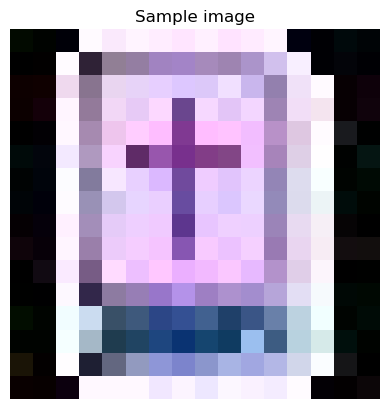

In [4]:
# Plotting an example from  the dataset
n = len(images)
integer = random.randint(0,n)
image = images[integer].numpy()*0.5 + 0.5

# Plot the image
plt.imshow(np.transpose(image, (1, 2, 0)))  
plt.axis('off')  # Hide axes
plt.title('Sample image')
plt.show()


<strong> Building the dataloader </strong>

In [5]:
dataloader = DataLoader(images, batch_size=256)

<strong> Building the models </strong>

In [6]:
latent_dim = 40
channels_out = 3
input_channels = 3
n_classes = 2

D_unet = Unet_Discriminator_V2(input_channels, n_classes)
G_unet = Unet_Generator_V2(latent_dim, channels_out)

<strong> Generating an image before training the generator </strong>

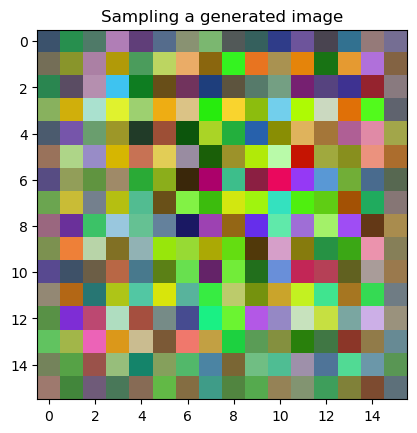

In [7]:
noise_image = D_unet(images[0].unsqueeze(0))[1][0]

# Generate random noise
noise = torch.randn(1, latent_dim, 1, 1)  # Batch of 16 noise vectors

# Generate images
fake_images = G_unet(noise)

# Plotting the image 
image_noise = fake_images.detach().numpy().reshape((3,16,16))*0.5 + 0.5

plt.imshow(np.transpose(image_noise, (1, 2, 0)))
plt.title("Sampling a generated image")
plt.show()

In [10]:
print('cuda' if torch.cuda.is_available() else 'cpu')

cpu


<strong> Training loop</strong>

In [8]:
torch.autograd.set_detect_anomaly(True)

input_channels = 3
n_classes = 2
k = 1 # Steps to train generator
latent_dim = 40

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device) 

G_unet = G_unet.to(device)
D_unet = D_unet.to(device)

criterion = unet_d_criterion_without_cutmix_v2

optimizer_g_unet = optim.Adam(G_unet.parameters(), lr=1e-4, betas=(0.5, 0.999))
optimizer_d_unet = optim.Adam(D_unet.parameters(), lr=5e-4, betas=(0.5, 0.999)) 

D_loss, G_loss = [], []

epochs = 1000
epoch_eval = epochs // 10

fid = FrechetInceptionDistance(feature=192, reset_real_features=False, normalize=True)
n_samples = 500
N = len(images)
indices = random.sample(range(N), n_samples)

real_images_eval = torch.stack([images[idx] for idx in indices])
fid.update(real_images_eval, real=True)

FID_values = []

for epoch in tqdm(range(epochs)):
    start_time = time.time()

    for batch in tqdm(dataloader):
        # Get real images
        real_images = batch.to(device)  # Move batch to GPU
        batch_size = real_images.size(0)
        labels_1 = torch.ones(batch_size, 1, device=device)  # Real labels on GPU
        labels_2 = torch.ones(batch_size, 1, device=device)

        # Train discriminator with real images
        D_unet.zero_grad()
        output = D_unet(real_images)
        loss_d_real = criterion(output, labels_1, batch_size)

        # Train discriminator with fake images
        noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)  # Generate noise on GPU
        fake_images = G_unet(noise)
        labels_2.fill_(0)  # Fake labels
        output = D_unet(fake_images.detach())
        loss_d_fake = criterion(output, labels_2, batch_size)
        
        loss_d = loss_d_fake + loss_d_real
        loss_d.backward()
        optimizer_d_unet.step()

        if epoch % k == 0:
            # Train generator
            labels_3 = torch.ones(batch_size, 1, device=device)
            G_unet.zero_grad()
            labels_3.fill_(1)  # Real labels
            output = D_unet(fake_images)
            loss_g = criterion(output, labels_3, batch_size)
            loss_g.backward()
            optimizer_g_unet.step()

    if epoch % epoch_eval == 0:
        # Eval mode
        G_unet_eval = G_unet.eval()
        # Generating fake images
        noise = torch.randn(n_samples, latent_dim, 1, 1, device=device)
        fake_images_eval = G_unet_eval(noise).to(torch.device('cpu'))
        fid.update(fake_images_eval, real=False)
        fid_value = fid.compute().item()
        FID_values.append(fid_value)
        # Storing loss values
        D_loss.append(loss_d.item())
        G_loss.append(loss_g.item())
        # Train mode
        G_unet.train()

            
    
    end_time = time.time()
    if epoch % k == 0:

        print(f'Epoch [{epoch}/{epochs}] | Loss D: {loss_d.item()} | Loss G: {loss_g.item()}')
    else:
    
        print(f'Epoch [{epoch}/{epochs}] | Loss D: {loss_d.item()}')
    
    print(f'Epoch {epoch +1} duration :   {end_time - start_time}')

cpu


KeyboardInterrupt: 

<strong> Sampling a generated image </strong>

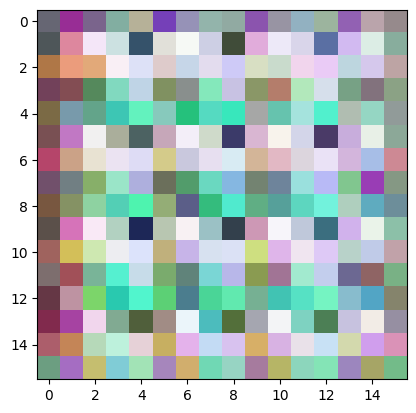

In [20]:
# Generate random noise
noise = torch.randn(1, latent_dim, 1, 1)  # Batch of 1 noise vector

G_unet_test = G_unet.to('cpu')
# Generate images
fake_images = G_unet_test(noise)

# Resize the generated image
resize_transform = transforms.Resize((16, 16))
resized_fake_images = resize_transform(fake_images)

# Convert to numpy array for visualization
image_noise = resized_fake_images.detach().numpy().reshape((3, 16, 16)) * 0.5 + 0.5

# Display the image
plt.imshow(np.transpose(image_noise, (1, 2, 0)))
plt.show()


<strong> Plotting losses </strong>

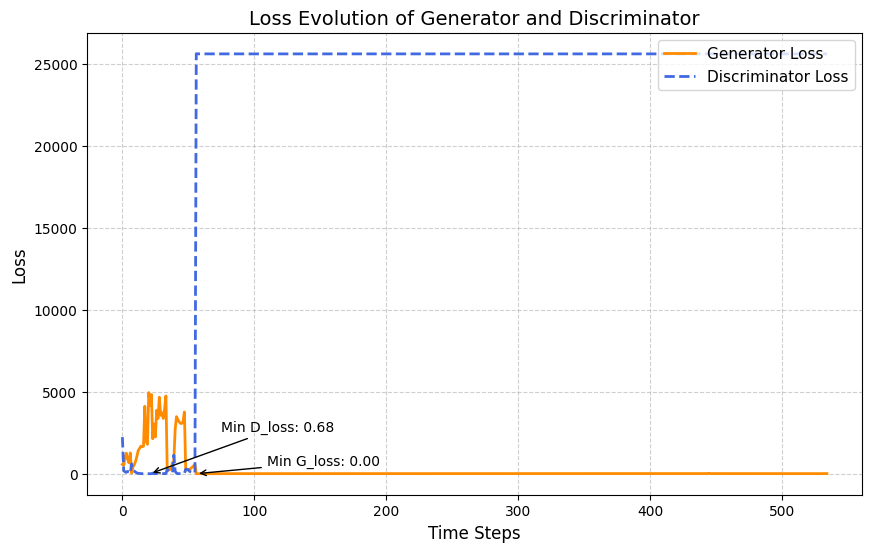

In [21]:
# Assuming G_loss and D_loss are defined
n = len(G_loss)
time_steps = [i for i in range(n)]

plt.figure(figsize=(10, 6))

# Plot Generator Loss
plt.plot(time_steps, G_loss, label='Generator Loss', color='darkorange', linestyle='-', linewidth=2)

# Plot Discriminator Loss
plt.plot(time_steps, D_loss, label='Discriminator Loss', color='royalblue', linestyle='--', linewidth=2)

# Add grid, labels, and title
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss Evolution of Generator and Discriminator', fontsize=14)

# Adding legend
plt.legend(loc='upper right', fontsize=11)

# Adding annotations for minimum loss points (optional)
min_G_loss = min(G_loss)
min_G_loss_idx = G_loss.index(min_G_loss)
plt.annotate(f'Min G_loss: {min_G_loss:.2f}', xy=(min_G_loss_idx, min_G_loss),
             xytext=(min_G_loss_idx + n*0.1, min_G_loss + max(G_loss)*0.1),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10)

min_D_loss = min(D_loss)
min_D_loss_idx = D_loss.index(min_D_loss)
plt.annotate(f'Min D_loss: {min_D_loss:.2f}', xy=(min_D_loss_idx, min_D_loss),
             xytext=(min_D_loss_idx + n*0.1, min_D_loss + max(D_loss)*0.1),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10)

# Show plot
plt.show()


<strong> Plotting FID (Fréchet Inception Distance) values </strong>

Text(0.5, 1.0, 'FID Evolution through training')

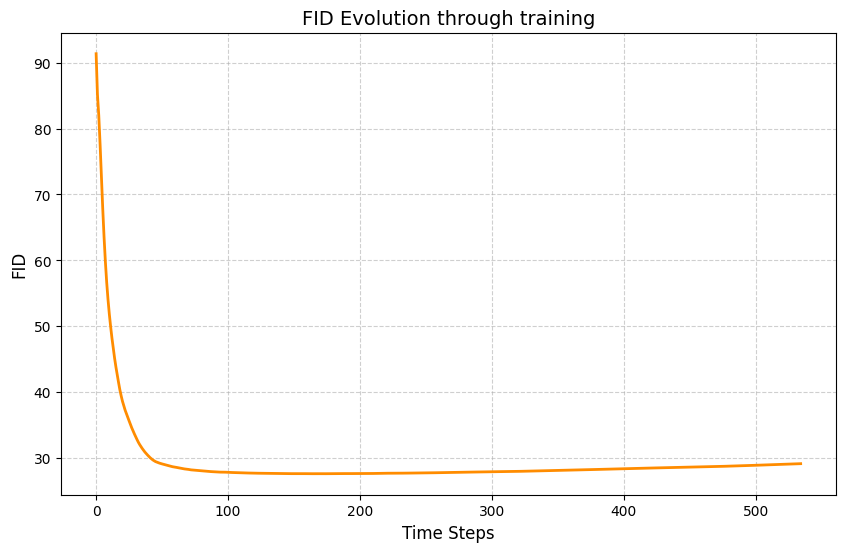

In [23]:
n = len(FID_values)
time_steps = [i for i in range(n)]

plt.figure(figsize=(10, 6))

# Plot FID values
plt.plot(time_steps, FID_values, label='Generator FID', color='darkorange', linestyle='-', linewidth=2)


# Add grid, labels, and title
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('FID', fontsize=12)
plt.title('FID Evolution through training', fontsize=14)